## 2023F-T3 AISC2007 - Deep Learning 

<hr>
Ungraded Study Case - Week 9

<hr>

### Author
**Fabio Duarte Junior**

 
### Description
> Use AI generative techniques to create at least 5 images of human faces that do not actually exist
> The professor provided us with a dataset of images of human beings in a variety of positions and scenarios, moods, with one or more faces, complete or partially obscured.

### My approach  

> I got Perplexity.AI and ChatGPT as my co-pilots and also class materials as reference.

> Issues :
>> 1 - Due to my OS behavior, I had to resume the process several times (for instance, when the screensaver starts, my Jupyter notebook kind of "pauses" the processing).
>> For this reason, I could not just run the entire notebook end-to-end in one go.

>> 2 - I made a mistake by not anticipating in my epoch implementations that I would have to resume the process, so the epoch numbers restarted with each resume action, 
>> ending up losing track of the true number of epochs. Fortunately, I saved all epoch metrics, so we can infer that the real number of epochs is the number of rows for the metrics.
 
>> 3 - Please ignore if you see any weird variation in the loss function; I was trying different new approaches.

>> 4 - The pre-processing of the images is not included in this code. I messed up the original pre-processing notebook, as my OpenCV stopped working in my environment and I had to change the approach.

>> But essentially, I used dlib and PIL to read each image in the repository, extract the faces, crop them from the original image, and save them into a new file.

# 00 - Libs

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
from IPython.display import Image, display, Markdown
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F

# 01 - Data and Configuation

In [2]:
latent_dim = 60
data_root  = 'test7'
batch_sz   = 32

## Enable my machine to use my laptop GPU through Apple Metal Performance Shaders architecthure (MPS)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [3]:
## Load data converting the shape to 64x64, also set a dataloader to get random examples through the batches.
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])
dataset    = datasets.ImageFolder(root=data_root, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_sz, shuffle=True)

## 02 - Variational Auto Encoder Model

In [4]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1), 
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), 
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), 
            nn.LeakyReLU(),
            nn.Flatten(),
        )
        
        ## Latent
        self.fc_mu = nn.Linear(256*4*4, latent_dim)
        self.fc_logvar = nn.Linear(256*4*4, latent_dim)

        ## Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256*4*4),
            nn.Unflatten(1, (256, 4, 4)),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

model = VAE().to(device)

# 03 - Loss Function

In [46]:
import math

def vae_loss(recon_x, x, mu, logvar):
    # MSE Loss
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return MSE   + KLD 

def sample_latent(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

def vae_loss(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    z_p = sample_latent(torch.zeros_like(mu), torch.zeros_like(logvar))
    z_q = sample_latent(mu, logvar)
    jsd = jensen_shannon_divergence(F.softmax(z_p, dim=1), F.softmax(z_q, dim=1))
    return MSE + jsd



def vae_loss(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x, reduction='sum')

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    M = 0.5 * (mu + torch.exp(logvar))
    JSD = 0.5 * (KLD + -0.5 * torch.sum(1 + logvar - M.pow(2) - logvar.exp()))

    return MSE + JSD

def vae_loss_BCE(recon_x, x, mu, logvar):    
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='none')
    BCE = BCE.view(-1).mean() * 64 * 64
    return BCE 
    
def vae_loss_MSE(recon_x, x, mu, logvar):
    # MSE Loss
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum') 
    return MSE 
    
def vae_loss_KLD(recon_x, x, mu, logvar):
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return KLD  

def vae_loss_JSD(recon_x, x, mu, logvar):
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    M = 0.5 * (mu + torch.exp(logvar))
    JSD = 0.5 * (KLD + -0.5 * torch.sum(1 + logvar - M.pow(2) - logvar.exp()))
    return JSD  

def vae_loss_RMSE(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum') 
    return MSE

# 04 - Auxiliar Function

In [6]:
## For saving the model
def save_checkpoint(state, filename="checkpoint.pth.tar"):
    torch.save(state, filename)

## 4.1 - Function to run the Epoch

In [110]:
prev_1=""
prev_2=""
def train(epoch):
    global prev_1
    global prev_2
    model.train()
    train_loss = 0
    len_batch = len(dataloader.dataset) 
    mse_batch = 0
    kld_batch = 0
    bce_batch = 0
    jsd_batch = 0
    
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        mse_batch+=vae_loss_MSE(recon_batch, data, mu, logvar)
        kld_batch+=vae_loss_KLD(recon_batch, data, mu, logvar)
        bce_batch+=vae_loss_BCE(recon_batch, data, mu, logvar)
        jsd_batch+=vae_loss_JSD(recon_batch, data, mu, logvar)

    for param_group in optimizer.param_groups:
        current_lr = param_group['lr']
        break   

    average_loss = train_loss / len(dataloader.dataset)

    markdown_table  = "| Epoch | Loss         | MSE          | KLD          | JSD          | BCE          | Time         | Current Learning Rate |\n"
    markdown_table += "|-------|--------------|--------------|--------------|--------------|--------------|--------------|--------------|\n"
    markdown_table += f"| {epoch:}  | **{average_loss:.8f}** |"
    markdown_table += f"{mse_batch/len_batch:.6f}|"
    markdown_table += f"{kld_batch/len_batch:.6f}|" 
    markdown_table += f"{jsd_batch/len_batch:.6f}| "
    markdown_table += f"{bce_batch/len_batch:.6f}| "
    end_time        = time.time()  
    elapsed_time    = end_time - start_time  # Calcula o tempo decorrido
    markdown_table += f"{elapsed_time:.2f} seconds |"
    markdown_table += f"{current_lr:.18f} |\n"
    display(Markdown(markdown_table))
    prev_1          = markdown_table
       
    if epoch > 1:
        display(Markdown("<hr> <br>"))
        markdown_table  = "| Loss diff    | MSE  Diff    | KLD Diff     | JSD Diff     | BCE Diff     |\n"
        markdown_table += "|--------------|--------------|--------------|--------------|--------------|\n"

        ldiff = t_loss[-1]-average_loss

        green_flag = "👍<span style='color:green;'> ⇩ "
        red_flag   = "👎🏼<span style='color:red;  '> ⇪ "
        
        if ldiff >0 :
            markdown_table += green_flag + f"{ldiff:.4f}</span>|"
        else:
            markdown_table += red_flag + f"{ldiff:.4f}</span>|"
        
        mdiff = t_mse[-1]-(mse_batch/len_batch)
        
        if t_mse[-1]-(mse_batch/len_batch) >0 :
            markdown_table += green_flag + f"{mdiff:.8f}</span>|"
        else:
            markdown_table += red_flag    + f"{mdiff:.8f}</span>|" 

        kdiff = t_kld[-1]-(kld_batch/len_batch) 
        
        if kdiff >0 :
            markdown_table += green_flag  + f"{kdiff:.8f}</span>|"
        else:
            markdown_table += red_flag    + f"<{kdiff:.8f}</span>|"

        bdiff = t_bce[-1]-(bce_batch/len_batch)
        
        if bdiff >0 :
            markdown_table += green_flag  + f"{bdiff:.8f}</span>|"
        else:
            markdown_table += red_flag    + f"{bdiff:.8f}</span>|"  

        jdiff = t_jsd[-1] - (jsd_batch/len_batch)
        if jdiff >0 :
            markdown_table += green_flag  + f"{jdiff:.8f}</span>|"
        else:
            markdown_table += red_flag    + f"{jdiff:.8f}</span>|"     
      
        display(Markdown(markdown_table))
        prev_2          = markdown_table
        
    display(Markdown("<hr>"))
    
    scheduler.step(average_loss)
    return average_loss, float(mse_batch/len_batch), float(kld_batch/len_batch),float(bce_batch/len_batch),float(jsd_batch/len_batch)

**Lists to store the metrics**

In [8]:
t_loss=[]
t_mse=[]
t_kld=[]
t_bce=[]
t_jsd=[]

**Functiion for ploting the metrics for a specified number of epochs**

In [73]:
def plot_50(num_epocs=50):
    display(Markdown("<hr>"))
    plt.figure(figsize=(15, 2))
    plt.plot(t_loss[-num_epocs:], label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')    
    plt.legend()
    plt.title('Training Curve last ' + str(num_epocs) + ' epochs')
    #plt.yscale('log') 
    plt.show()

    plt.figure(figsize=(15, 2))
    plt.plot(t_mse[-num_epocs:], label='MSE')

    plt.ylabel('MSE')    
    plt.legend()
    plt.show()

    plt.figure(figsize=(15, 2))
    plt.plot(t_kld[-num_epocs:], label='KLD')

    plt.ylabel('KLD')    
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(15, 2))
    plt.plot(t_jsd[-num_epocs:], label='JSD')
    plt.xlabel('Epochs')
    plt.ylabel('JSD')    
    plt.legend()

    plt.show()    
    

# 05 - Optimizer, Learning Rate and Reduce On Plateau

In [72]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

In [147]:
scheduler = ReduceLROnPlateau(optimizer, 'min', 
                              patience=1, 
                              factor=0.55, 
                              threshold=0.09,
                              min_lr=0.0000000000000000000000001,
                                    
                              verbose=True)

# 06 - Training the model

| Epoch | Loss         | MSE          | KLD          | JSD          | BCE          | Time         | Current Learning Rate |
|-------|--------------|--------------|--------------|--------------|--------------|--------------|--------------|
| 113  | **72.00085164** |33.749187|45.775295|38.251659| 73.618530| 4.26 seconds |0.000000002386039979 |


| Loss diff    | MSE  Diff    | KLD Diff     | JSD Diff     | BCE Diff     |
|--------------|--------------|--------------|--------------|--------------|
👎🏼<span style='color:red;  '> ⇪ -0.1145</span>|👎🏼<span style='color:red;  '> ⇪ -0.11447906</span>|👎🏼<span style='color:red;  '> ⇪ <0.00000000</span>|👎🏼<span style='color:red;  '> ⇪ -0.01129913</span>|👍<span style='color:green;'> ⇩ 0.00000763</span>|

<hr>

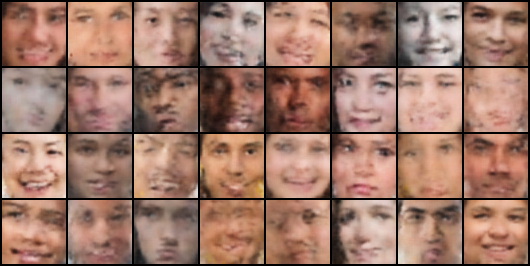

<hr>

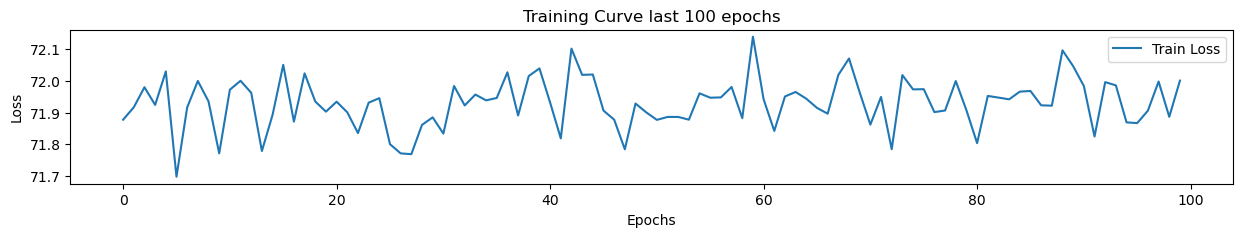

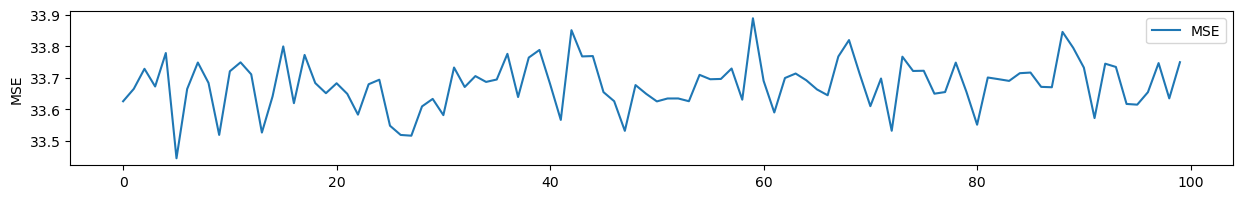

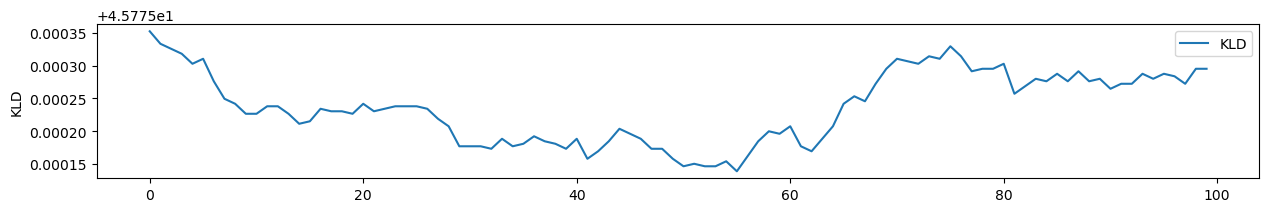

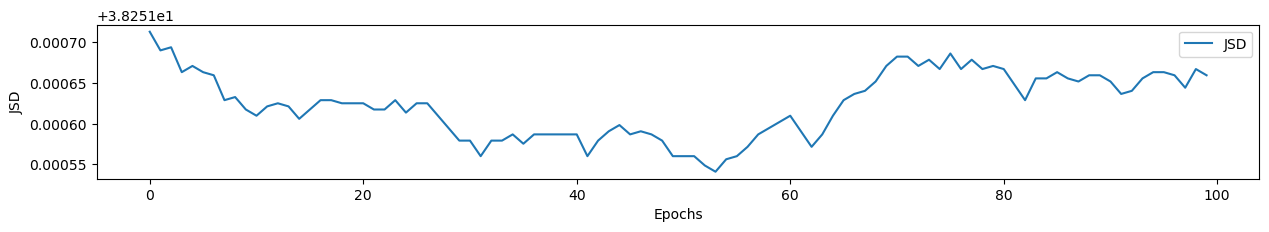

<hr>

In [ ]:
%%time
num_epochs  = 10000
num_samples = 32
from IPython.display import clear_output

def clear_cell_output():
    clear_output(wait=True)
    
for epoch in range(1, num_epochs+1):
    start_time = time.time()  # Inicia a contagem do tempo
    e_loss,e_mse,e_kld,e_bce,e_jsd = train(epoch)
    t_loss.append(e_loss)
    t_mse.append(e_mse)
    t_kld.append(e_kld)
    t_jsd.append(e_jsd)
    t_bce.append(e_bce)
    if epoch % 1  == 0:
        clear_cell_output()
        display(Markdown(prev_1))
        display(Markdown(prev_2))
        display(Markdown("<hr>"))
        with torch.no_grad():
            sample = torch.randn(num_samples, latent_dim).to(device)
            sample = model.decoder(sample).cpu()
            save_image(sample.view(num_samples, 3, 64, 64), f'results/sample_mse_64_JSDv7_{epoch}.png')
            save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }, filename=f"vae-torch-mse-64JSDv7_{epoch}.pth.tar")    
        image_path = f'results/sample_mse_64_JSDv7_{epoch}.png'
        display(Image(filename=image_path))
        plot_50(100)
        display(Markdown("<hr>"))

# 07 - Metrics

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(t_loss, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(t_mse, label='MSE')
plt.plot(t_kld, label='KLD')
plt.plot(t_jsd, label='JSD')
plt.legend()
plt.title('Training Curve')
plt.yscale('log') 
plt.show()

In [ ]:
plt.figure(figsize=(10, 2))
plt.plot(t_loss[25:], label='Epoch Loss')
#plt.yscale('log') 
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss Curve')
plt.show()
plt.figure(figsize=(10, 2))
plt.plot(t_mse[25:], label='MSE')
#plt.yscale('log') 
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training MSE')
plt.show()
plt.figure(figsize=(10, 2))
plt.plot(t_kld[25:], label='KLD')
#plt.yscale('log') 
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training KLD')
plt.show()
plt.figure(figsize=(10, 2))
plt.plot(t_jsd[25:], label='JSD')
plt.yscale('log') 
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training JSD')
plt.show()

# 08 - Let's see some results

In [ ]:
%%time
num_samples = 1000

with torch.no_grad():
    sample = torch.randn(num_samples, latent_dim).to(device)
    sample = model.decoder(sample).cpu()
    save_image(sample.view(num_samples, 3, 64, 64), f'results/final_mse_64_JSDv7_{epoch}.png')

image_path = f'results/final_mse_64_JSDv7_{epoch}.png'
display(Image(filename=image_path))